# Example 1. Difussion 

This example aim to set up a simple diffussion problem for demostrating the workflow of running the problem on CPU and also ploting the result

In [1]:
using MHDFlows,PyPlot
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/IWexK/src/FourierFlows.jl:123


In [2]:
# Declare the problem on CPU
CPUprob  = Problem(CPU();nx = 32,Lx = 2π,
                                  ν = 1/10,
                                 nν = 1,
                                  η = 1/10, 
                   # Timestepper and equation options
                                 dt = 1/50,
                            stepper = "RK4",
                   # Float type and dealiasing
                                  T = Float64);
CPUprob

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on CPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [3]:
# function of setting up the initial condition
function ProblemGenerator3D!(prob,L;N = prob.grid.nx)

  xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = prob.grid.x[i];
    yy[i,j,k] = prob.grid.y[j];
    zz[i,j,k] = prob.grid.z[k];
  end
    
  sl=1; sk=1; sm=1; lamlkm=sqrt(sl.^2+sk.^2+sm.^2);

  ux = @. -0.5*(lamlkm*sl*cos(sk*xx).*sin(sl*yy).*sin(sm.*zz) +sm*sk*sin(sk*xx).*cos(sl*yy).*cos(sm.*zz));
  uy=  @.  0.5*(lamlkm*sk*sin(sk*xx).*cos(sl*yy).*sin(sm.*zz)-sm*sl*cos(sk*xx).*sin(sl*yy).*cos(sm.*zz));
  uz=  @.                 cos(sk*xx).*cos(sl*yy).*sin(sm.*zz);

  #Update V + B Conponment to Problem
  SetUpProblemIC!(prob; ux = ux, uy = uy, uz = uz);

  return nothing
    
end

ProblemGenerator3D! (generic function with 1 method)

In [4]:
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

KE = MHDFlows.Diagnostic(KEfoo, CPUprob);

In [5]:
# Set up the initial condition
ProblemGenerator3D!(CPUprob,2π);

# Actaul computation
TimeIntegrator!(CPUprob,5.0,100;
                diags = [KE],
          loop_number = 100,
	             save = false);

Total CPU/GPU time run = 7.531 s, zone update per second = 274123.163 


## Result

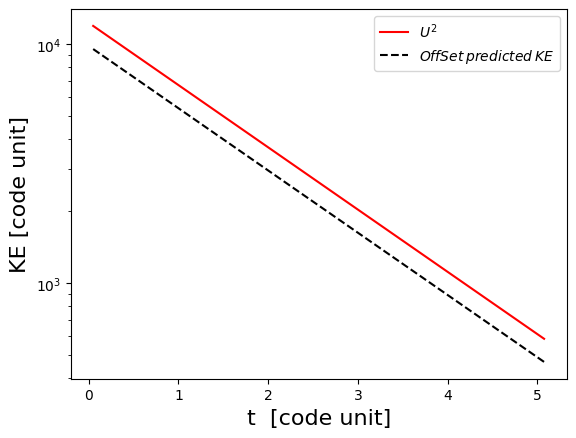

PyObject Text(30.000000000000007, 0.5, 'KE [code unit]')

In [6]:
n = KE.i
t  = KE.t[2:n];
u0 = KE.data[2];
plot(KE.t[2:n],KE.data[2:n],"r",label=L"U^2")
semilogy(KE.t[2:n],exp.(-2*3*(t.-t[1])/10)*u0*0.8,"k--",label=L"OffSet\:predicted\:KE");
legend()
xlabel("t  [code unit]",size=16)
ylabel("KE [code unit]",size=16)